This file was used to test models on a single user.

In [25]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator, Toy_intensity_Comparer
import torch
import torch.optim as optim
import torch.nn as nn
import pytorch_warmup as warmup

import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import simtrain.utils as utils
from tqdm import tqdm
import evotorch
import ray
from functools import partial
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from simtrain.Dataset import TimestepFrequencyDataset

os.environ['PYTHONPATH'] = "/home/thahit/github/Recommender_Sim"
#ray.init(ignore_reinit_error=True)


In [26]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [27]:
sfaf

NameError: name 'sfaf' is not defined

# Data

## Generated Data
Fake data generated by a neural network.

In [ ]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [ ]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
state = torch.zeros((1, state_size))

In [ ]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)
samples

array([[2.1],
       [0.4],
       [0.2],
       [0.6],
       [2.2],
       [7.6],
       [0.6],
       [1.1],
       [1.3],
       [0.3],
       [0.1],
       [0.5],
       [0.1],
       [0. ],
       [1.4],
       [3.8],
       [2.7],
       [2. ],
       [2. ],
       [0. ],
       [0.1],
       [0.4],
       [2.3],
       [1.8],
       [0. ],
       [0.1],
       [1.1],
       [2.1],
       [2.3],
       [1.5],
       [1.3],
       [1.6],
       [0.5],
       [1.1],
       [0.4],
       [1.1],
       [1.2],
       [0.1],
       [1.8],
       [0.8],
       [0.4],
       [0.9],
       [1.2],
       [0.5],
       [0.7],
       [0.1],
       [1.6],
       [2.2],
       [1.5],
       [0.4],
       [3.4],
       [0.3],
       [3.3],
       [2.3],
       [0.4],
       [1.2],
       [4. ],
       [2.5],
       [0.5],
       [0.6],
       [0.8],
       [0.4],
       [3.3],
       [3.9],
       [0.7],
       [0.6],
       [0.1],
       [0.7],
       [1.9],
       [0.4],
       [1.1],
      

feed in true values for fake models, 


/tmp/ipykernel_14494/2138906594.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)


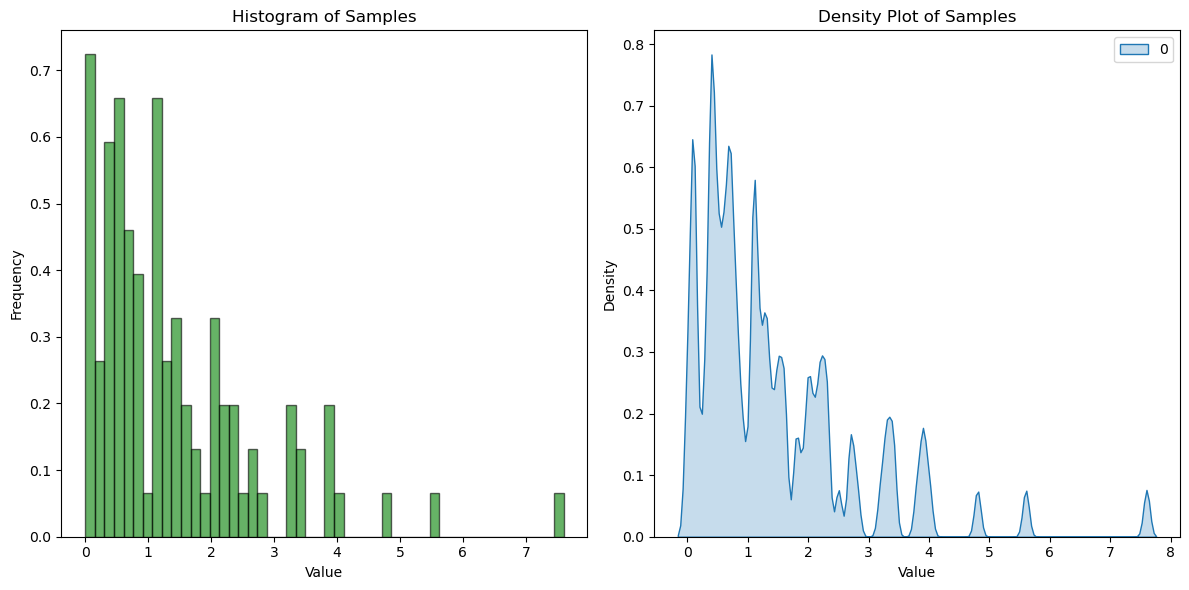

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [ ]:
sample_path = gen_model.sample_path(num_samples=5)
sample_path =torch.tensor(sample_path)
sample_path

tensor([[2.7000],
        [3.4000],
        [4.9000],
        [5.4000],
        [6.5000]])

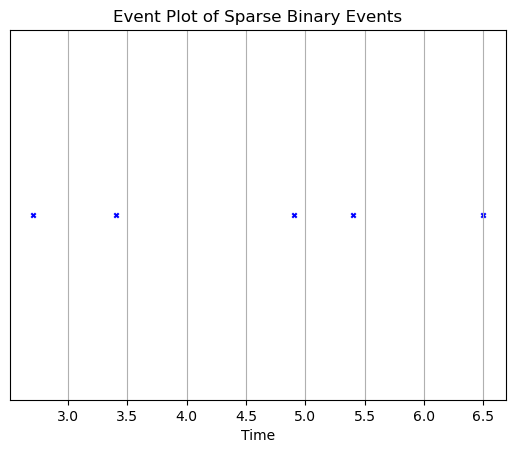

In [ ]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


In [ ]:
asdafa

## Real data

In [28]:
checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             "testing", "data.h5"))
list_of_dicts = checkpoint['data']
chosen_sample = list_of_dicts[4]["timestamps"]
sample_path =torch.tensor(chosen_sample)
sample_path

tensor([ 5.0833,  6.3958, 11.8125, 28.0417, 28.2708, 40.1042, 42.8542])

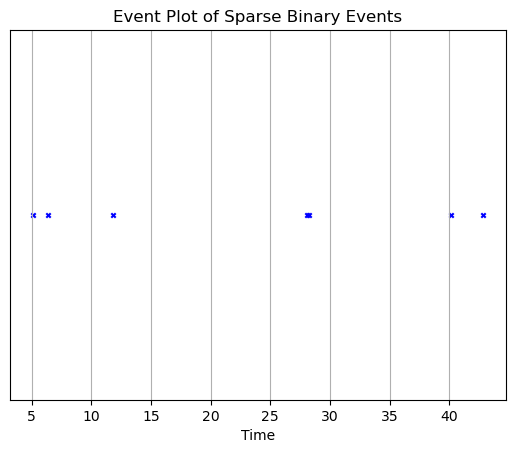

In [29]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


# Model Samples

## Train Gradient Descent
Not working

### base

In [ ]:
def train_single(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += torch.log(scoring_func(current_pred, timestep))
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()


In [ ]:
# parameter dicts
width= 16
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(train_model.parameters(), lr=0.1,
                        weight_decay=1e-7)


In [ ]:
#train_single(train_model, sample_path, scoring_func=utils.energy_score_loss,
#            optimizer=optimizer, num_epochs=30, num_tries=10)

### function approximation



In [ ]:
from simtrain.sim_models_new import all_in_one_model

width=64
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }
            

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat)

In [ ]:
from simtrain.train import train_single_function_approx

In [ ]:
steps_per_epoch = 1

num_epochs = 1500
warmup_period = steps_per_epoch * 10
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = num_steps + 1
user_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-7)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, loss_print_interval=num_epochs//20,
            warmup_period=warmup_period)


  0%|          | 5/1500 [00:00<01:19, 18.82it/s]

epch: 0 loss_sum: 78.0014


  5%|▌         | 80/1500 [00:02<00:37, 37.81it/s]

epch: 75 loss_sum: 65.9738


 10%|█         | 156/1500 [00:04<00:36, 37.20it/s]

epch: 150 loss_sum: 29.1634


 15%|█▌        | 232/1500 [00:06<00:35, 35.71it/s]

epch: 225 loss_sum: 23.8795


 20%|█▉        | 297/1500 [00:08<00:33, 36.22it/s]


KeyboardInterrupt: 

In [ ]:
sdfsdf

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.0001,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=3000,timecheat=timecheat, num_tries=20, 
            loss_print_interval=20, state_size=state_size,)

In [ ]:
adsfasdf

## Train via Evolution

In [ ]:
from evotorch.algorithms import PGPE, CMAES
from evotorch.logging import PandasLogger
from functools import partial


In [ ]:
# parameter dicts
width= 64
user_state_dict = {"model_hyp": {"layer_width": [width,width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width,width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:

def eval_single(model, path, scoring_func, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    loss = 0.
    #results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return loss


eval_single_partial = partial(eval_single, path=sample_path, scoring_func=utils.energy_score_loss,
                              num_tries=30)

In [ ]:
eval_single_partial(train_model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Single_path_problem = evotorch.neuroevolution.NEProblem(
    objective_sense="min",
    network= train_model,
    #network=Toy_intensity_Generator,
    #network_args = {"hyperparameter_dict": hyperparameter_dict},
    network_eval_func=eval_single_partial,
    device=device,
    num_actors = 20,
)

In [ ]:


searcher = PGPE(
    Single_path_problem,
    popsize=40,
    radius_init=5.,
    center_learning_rate=0.2,
    stdev_learning_rate=0.05,
)
'''
searcher = CMAES(
    Single_path_problem,
    popsize=20,  
    stdev_init= 2.
)'''

logger = PandasLogger(searcher)



In [ ]:
num_iterations = 20
for _ in tqdm(range(num_iterations), desc="Running PGPE"):
    searcher.step()

1 epoch = 50(population) * 20(samples for expectation) * 1(number of paths) * 10'000(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 300m NN calls per epoch

for much worse approximation and still way too much compute:<br>
1 epoch = 20(population) * 20(samples for expectation) * 1(number of paths) * 100(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 1.2m NN calls per epoch


lstm/rnn  feed last hidden state + actual state to predict probability increase,  stop at  threshhold chosen by uniform 


neural network(time? + state)  -> time + state

noise for time but not state

normalizing flows?

In [ ]:
logger.to_dataframe().mean_eval.plot()# test datapoint CMA ES

In [ ]:
asdcas

In [ ]:
trained_network = Single_path_problem.parameterize_net(searcher.status["center"])


In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(trained_network.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))
#trained_network = train_model

# Model Intensity

In [30]:
train_sorted = False
batchsize = 1  # needs to be 1 for ode
model_type = "simple"

In [31]:
width=64
intensity = {"model_hyp": {"layer_width": [width for _ in range(3)]}}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)],
                            "noise": 0},
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
        "intensity_model": intensity, "state_model_type": model_type, # simple
        "time_embedding_size" :32, "max_freq": 20,
        }
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)


Toy_intensity_Comparer(
  (user_state_model): User_State_Model(
    (ode_func): Ode_Function(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=64, bias=True)
        (1): SiLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): SiLU()
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): SiLU()
        (6): Linear(in_features=64, out_features=64, bias=True)
        (7): SiLU()
        (8): Linear(in_features=64, out_features=4, bias=True)
      )
    )
  )
  (intensity_model): User_State_Intensity_Model_simple(
    (model): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [32]:
dataset = TimestepFrequencyDataset(sample_path, num_random_points=150)

for i in range(min(len(dataset), 20)):
    sample = dataset[i]
    print(f"Timestep: {sample['timestep'].item():.4f}, Frequency: {sample['frequency'].item()}")

dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=not train_sorted
                        )

Timestep: 0.0000, Frequency: 0.0
Timestep: 0.4698, Frequency: 0.0
Timestep: 0.9396, Frequency: 0.0
Timestep: 1.4094, Frequency: 0.0
Timestep: 1.8792, Frequency: 0.0
Timestep: 2.3490, Frequency: 0.0
Timestep: 2.8188, Frequency: 0.0
Timestep: 3.2886, Frequency: 0.0
Timestep: 3.7584, Frequency: 0.0
Timestep: 4.2282, Frequency: 0.0
Timestep: 4.6980, Frequency: 0.0
Timestep: 5.0833, Frequency: 2.0
Timestep: 5.1678, Frequency: 2.0
Timestep: 5.6376, Frequency: 0.0
Timestep: 6.1074, Frequency: 0.0
Timestep: 6.3958, Frequency: 2.0
Timestep: 6.5772, Frequency: 2.0
Timestep: 7.0470, Frequency: 0.0
Timestep: 7.5168, Frequency: 0.0
Timestep: 7.9866, Frequency: 0.0


In [33]:
for batch in dataloader:
    print(batch)
    break

{'timestep': tensor([51.6779]), 'frequency': tensor([0.])}


In [34]:
steps_per_epoch = len(dataset) // batchsize  
if len(dataset) % batchsize  != 0:
    steps_per_epoch+=1
num_epochs = 200
warmup_period = steps_per_epoch
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = num_steps + 1
user_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [35]:
from simtrain.train import train_density

def train_density_sorted():
    pass

def print_res(model, dataloader, criterion,state_size):
    for batch in dataloader:
        timesteps = batch['timestep'].unsqueeze(1)  # Add batch dimension
        frequencies = batch['frequency']
        state = torch.zeros((len(timesteps), state_size))
        optimizer.zero_grad()
        
        outputs = model(state, timesteps)

        loss = criterion(outputs, frequencies)  # Remove extra dimension from output
        print(f"loss: {loss} \tfrequencies: {frequencies} \t predicted: {outputs}, \ttime: {timesteps}")
        loss.backward()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Gradients: {param.grad}")


In [36]:
from simtrain.utils import weighted_mse_loss
loss = partial(weighted_mse_loss, weight_pos=5)

In [37]:
train_density(model, dataloader, criterion=weighted_mse_loss, state_size=state_size,
                optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
                loss_print_interval=1, warmup_period=warmup_period, lr_scheduler=lr_scheduler)

  0%|          | 1/200 [00:09<31:49,  9.60s/it]

epch: 0 loss_sum: 93.7702


  1%|          | 2/200 [00:19<32:13,  9.76s/it]

epch: 1 loss_sum: 88.7760


  2%|▏         | 3/200 [00:28<31:39,  9.64s/it]

epch: 2 loss_sum: 88.2722


  2%|▏         | 4/200 [00:38<31:57,  9.78s/it]

epch: 3 loss_sum: 88.1442


  2%|▎         | 5/200 [00:49<32:08,  9.89s/it]

epch: 4 loss_sum: 88.0732


  3%|▎         | 6/200 [00:59<32:03,  9.92s/it]

epch: 5 loss_sum: 88.0422


  4%|▎         | 7/200 [01:10<33:09, 10.31s/it]

epch: 6 loss_sum: 88.0248


  4%|▍         | 8/200 [01:23<35:37, 11.13s/it]

epch: 7 loss_sum: 88.0152


  4%|▍         | 9/200 [01:34<36:13, 11.38s/it]

epch: 8 loss_sum: 88.0099


  5%|▌         | 10/200 [01:45<35:13, 11.13s/it]

epch: 9 loss_sum: 88.0068


  6%|▌         | 11/200 [01:55<34:01, 10.80s/it]

epch: 10 loss_sum: 88.0050


  6%|▌         | 12/200 [02:06<33:30, 10.69s/it]

epch: 11 loss_sum: 88.0037


  6%|▋         | 13/200 [02:15<32:30, 10.43s/it]

epch: 12 loss_sum: 88.0028


  7%|▋         | 14/200 [02:26<32:45, 10.57s/it]

epch: 13 loss_sum: 88.0022


  8%|▊         | 15/200 [02:38<33:19, 10.81s/it]

epch: 14 loss_sum: 88.0017


  8%|▊         | 16/200 [02:49<33:52, 11.04s/it]

epch: 15 loss_sum: 88.0014


  8%|▊         | 16/200 [02:50<32:43, 10.67s/it]


KeyboardInterrupt: 

#### visualize training

In [ ]:
#dataloader = DataLoader(dataset, batch_size=1, shuffle=not train_sorted) 

In [38]:
print(len(dataset))

157


In [39]:
print_res(model, dataloader, weighted_mse_loss, state_size=state_size,)

loss: 0.0 	frequencies: tensor([0.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[29.1275]])
loss: 0.0 	frequencies: tensor([0.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[56.3758]])
loss: 0.0 	frequencies: tensor([0.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[36.1745]])
loss: 16.0 	frequencies: tensor([4.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[28.2708]])
loss: 4.0 	frequencies: tensor([2.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[5.1678]])
loss: 0.0 	frequencies: tensor([0.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[39.4631]])
loss: 0.0 	frequencies: tensor([0.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[18.7919]])
loss: 0.0 	frequencies: tensor([0.]) 	 predicted: tensor([[0.]], grad_fn=<SoftplusBackward0>), 	time: tensor([[30.0671]])
loss: 0.0 	frequencies: 

area: 0.0125445856153965


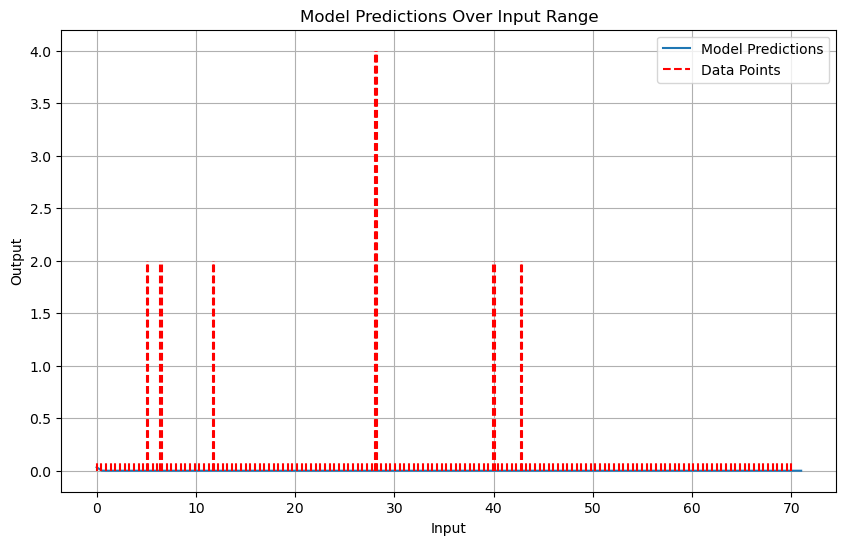

In [56]:
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.zeros((len(x_range), state_size))
        predictions = model(state, x_range_tensor).numpy()

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sfdsd

In [ ]:
x_range = np.linspace(-1, 70, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    if model_type == "ode":
        predictions = []
        for el in x_range_tensor:
            predictions.append(model(el, x_range_tensor).item())
    else:
        predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height =sample['frequency'].item()+.1
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x_range = np.linspace(-1, 70, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height =sample['frequency'].item()+.1
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x_range = np.linspace(-1, 70, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height =sample['frequency'].item()+.1
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

# Visualize samples

In [ ]:
trained_network = train_model

In [ ]:

def simulate_single_forced(model, path, num_tries=20, state = torch.zeros((1, state_size))):
    
    last_t = 0
    
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            print(f"var(forced): {torch.var(current_pred)}")
            #loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return results


def simulate_single(model, num_events, num_tries=20, state = torch.zeros((1, state_size))):
    
    last_t = 0
    results = []
    with torch.no_grad():
        for i in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            print(f"var: {torch.var(current_pred)}")
            selected = torch.mean(current_pred)
            results.append(selected)
            delta = selected-last_t
            last_t = selected
            state = model.evolve_state(state, delta)
    
    return results




In [ ]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    utils.simulate_single_forced_function_approx, path=sample_path,
                              num_tries=1, timecheat=timecheat, state_size=state_size)
simulate_single_partial_function_approx =partial(
    utils.simulate_single_function_approx, num_events =len(sample_path),
                              num_tries=1, timecheat=timecheat, state_size=state_size)

In [ ]:
# integrals
simulate_single_partial_forced = partial(simulate_single_forced, path=sample_path, 
                              num_tries=2)

simulate_single_partial = partial(simulate_single, num_events=12,
                              num_tries=2)


In [ ]:
# intensity
example_out_forced = simulate_single_partial_forced(trained_network)
example_out = simulate_single_partial(trained_network)

NameError: name 'simulate_single_partial_forced' is not defined

In [ ]:
#mlp
example_out_forced = simulate_single_partial_forced_function_approx(trained_network)
example_out = simulate_single_partial_function_approx(trained_network)

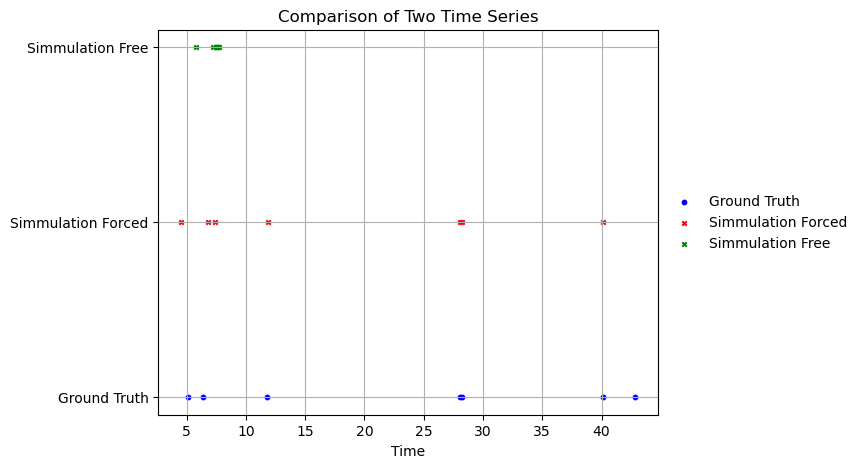

In [ ]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
asdfasf

In [ ]:
# 3 layers
import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
SCA

In [ ]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
scsdc

In [ ]:
state = torch.zeros((1, state_size))
samples = [train_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()
